#  Projet2: NLP et Techniques Avancées

In [1]:
!pip install wordcloud

In [2]:
!pip install tensorflow==2.15.0

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout,Input, Attention,GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.models import Model

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

2025-03-03 23:37:07.290309: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-03 23:37:07.290358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-03 23:37:07.291589: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 23:37:07.297704: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-03 23:37:08.086408: W tensorflow/compiler/tf2

# 1- Data Preparation

In [5]:
#from google.colab import files
#uploaded = files.upload()


In [4]:
# Charger le dataset
data = pd.read_csv('ChatGPT_Reviews.csv')

In [5]:
data.head()

,Review Id,Review,Ratings,Review Date
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,8/23/2024 19:30
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,8/23/2024 19:28
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,8/23/2024 19:22
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,8/23/2024 19:20
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,8/23/2024 19:20


In [6]:
data.tail()

,Review Id,Review,Ratings,Review Date
196722,462686ff-e500-413c-a6b4-2badc2e3b21d,Update 2023,5,7/27/2023 16:26
196723,f10e0d48-ecb6-42db-b103-46c0046f9be9,its grear,5,9/23/2023 16:25
196724,df909a49-90b5-4dac-9b89-c4bd5a7c2f75,Funtastic App,5,11/8/2023 13:57
196725,abe43878-973f-4e96-a765-c4af5c7f7b20,hi all,5,7/25/2023 15:32
196726,0151001d-b81c-41b5-8927-f56738989625,expert application,5,11/30/2023 18:11


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196727 entries, 0 to 196726
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Review Id    196727 non-null  object
 1   Review       196721 non-null  object
 2   Ratings      196727 non-null  int64 
 3   Review Date  196727 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.0+ MB


In [8]:
data.shape

(196727, 4)

In [7]:

df = data.iloc[:100000]

In [9]:
df.shape

(100000, 4)

In [39]:
df.dtypes

Review Id      object
Review         object
Ratings         int64
Review Date    object
dtype: object

In [8]:
df.isnull().sum()

Review Id      0
Review         2
Ratings        0
Review Date    0
dtype: int64

##### Dealing with the missing values

In [41]:
# dropping the rows with content missing values
df.dropna(subset = ['Review'],inplace=True)

/tmp/ipykernel_1952/3145916516.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset = ['Review'],inplace=True)


In [42]:
# Count the total number of duplicate rows
total_duplicates = df[df.duplicated(keep='first')].shape[0]

print("Total duplicate rows:", total_duplicates)

Total duplicate rows: 2291


#### Drop the duplicated rows

In [43]:
# Drop duplicate rows
df.drop_duplicates(keep='first', inplace=True)

# Reset the index after dropping duplicates
df.reset_index(drop=True, inplace=True)

/tmp/ipykernel_1952/1602904912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(keep='first', inplace=True)


In [44]:
df.shape

(97707, 4)

In [45]:
df['Review']

0                                                     good
1                                                     good
2                                                 nice app
3                                                 nice, ig
4        this is a great app, the bot is so accurate to...
                               ...                        
97702    Chatgpt helps me in studies and skill developm...
97703    As an AI language model, I don't have feelings...
97704                                 perfect for students
97705    it really helps me to my studies and to other ...
97706    it's a very good app . It's very helpful for s...
Name: Review, Length: 97707, dtype: object

In [10]:
df.Review.unique()

array(['good', 'nice app', 'nice, ig', ...,
       "As an AI language model, I don't have feelings or self-awareness, so I don't have a personal opinion or the ability to rate myself. However, I was designed and trained by OpenAI to be a highly capable language model based on the GPT-3.5 architecture, and I strive to provide helpful and informative responses to the best of my abilities. My performance largely depends on the quality and diversity of the data I was trained on, as well as the ongoing efforts by developers to improve and fine-tune th",
       'it really helps me to my studies and to other things to',
       "it's a very good app . It's very helpful for students."],
      dtype=object)

## Exploratory Data Analysis

#### Reviews distribution

/tmp/ipykernel_1635/2963037553.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Review_Length"] = df["Review"].astype(str).apply(len)


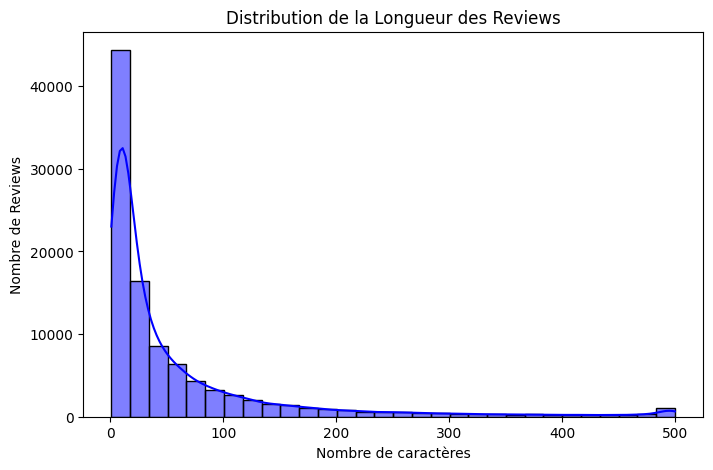

In [10]:
df["Review_Length"] = df["Review"].astype(str).apply(len)

# Histogramme des longueurs de reviews
plt.figure(figsize=(8,5))
sns.histplot(df["Review_Length"], bins=30, kde=True, color="blue")
plt.title("Distribution de la Longueur des Reviews")
plt.xlabel("Nombre de caractères")
plt.ylabel("Nombre de Reviews")
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


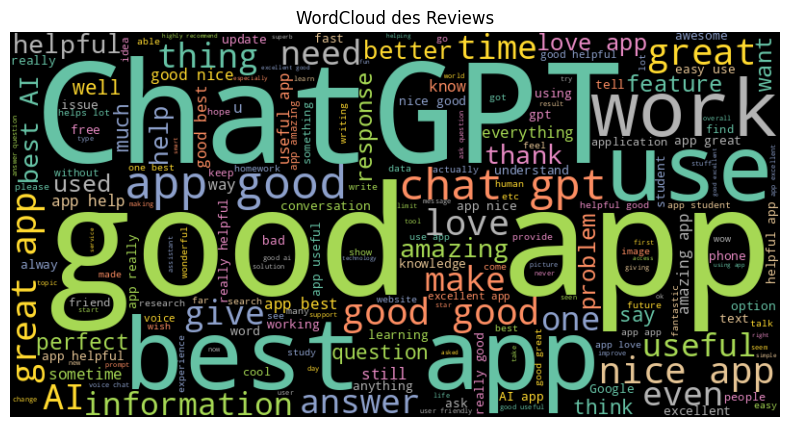

In [12]:
from wordcloud import WordCloud

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Fusionner tous les commentaires
all_words = " ".join(df["Review"].dropna())

# Nettoyage des mots communs et stopwords
words = " ".join([word for word in all_words.split() if word.lower() not in stop_words])

# Générer un nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="Set2").generate(words)

# Afficher le WordCloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud des Reviews")
plt.show()


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/tmp/ipykernel_116998/2532382970.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Fréquence", y="Mot", data=word_freq_df, palette="viridis")


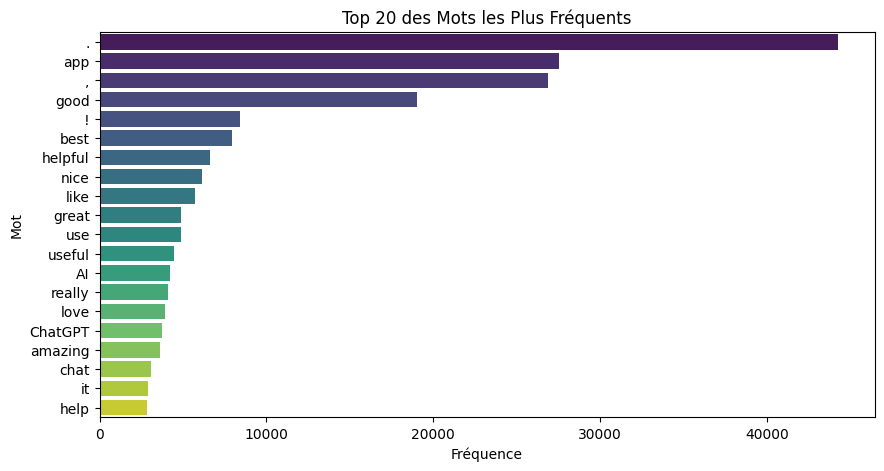

In [13]:
import nltk
nltk.download('punkt_tab') # Download the 'punkt_tab' resource
from collections import Counter
from nltk.tokenize import word_tokenize



# Tokenization et comptage des mots
words = word_tokenize(words)
word_freq = Counter(words)

# Convertir en DataFrame pour affichage
word_freq_df = pd.DataFrame(word_freq.most_common(20), columns=["Mot", "Fréquence"])

# Affichage sous forme de barplot
plt.figure(figsize=(10,5))
sns.barplot(x="Fréquence", y="Mot", data=word_freq_df, palette="viridis")
plt.title("Top 20 des Mots les Plus Fréquents")
plt.show()

## Text Analysis with NLP Preprocessing

### Text Cleaning & Preprocessing

Les étapes incluent :

Conversion en minuscules

Suppression des caractères spéciaux et ponctuation

Suppression des nombres

Suppression des mots vides (stopwords)

Lemmatisation (réduction des mots à leur forme de base)

In [14]:
# Téléchargement des ressources NLP nécessaires
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialisation du lemmatizer et des stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Fonction de nettoyage
def clean_text(text):
    if isinstance(text, str):  # Vérifier si le texte est une chaîne de caractères
        text = text.lower()  # Convertir en minuscules
        text = re.sub(r'\d+', '', text)  # Supprimer les nombres
        text = text.translate(str.maketrans('', '', string.punctuation))  # Supprimer la ponctuation
        words = word_tokenize(text)  # Tokenization
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Stopwords & lemmatisation
        return ' '.join(words)
    else:
        return ""

# Appliquer le nettoyage à la colonne Review
df['Cleaned_Review'] = df['Review'].apply(clean_text)
df = df[df["Cleaned_Review"].str.strip() != ""]  # Supprimer les reviews vides après nettoyage

# Affichage des 5 premières lignes
print(df[['Review', 'Cleaned_Review']].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                              Review  \
0                                               good   
1                                               good   
2                                           nice app   
3                                           nice, ig   
4  this is a great app, the bot is so accurate to...   

                                      Cleaned_Review  
0                                               good  
1                                               good  
2                                           nice app  
3                                            nice ig  
4  great app bot accurate anything give tip gamin...  


/tmp/ipykernel_116998/3009433383.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cleaned_Review'] = df['Review'].apply(clean_text)


### Encodage des Labels pour Classification

Nous allons transformer les ratings (1-5) en 3 catégories pour une classification multi-classes :

0 → Négatif (1 & 2 étoiles)

1 → Neutre (3 étoiles)

2 → Positif (4 & 5 étoiles)

<Axes: title={'center': 'Distribution des Sentiments'}, xlabel='Sentiment'>

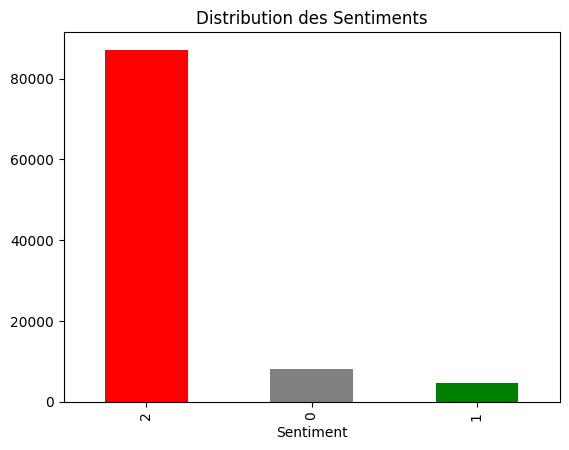

In [15]:
def encode_sentiment(rating):
    if rating <= 2:
        return 0  # Négatif
    elif rating == 3:
        return 1  # Neutre
    else:
        return 2  # Positif

df["Sentiment"] = df["Ratings"].apply(encode_sentiment)

# Vérification de la répartition des classes
df["Sentiment"].value_counts().plot(kind="bar", color=["red", "gray", "green"], title="Distribution des Sentiments")


## Model training and evaluation

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["Cleaned_Review"], df["Sentiment"], test_size=0.2, random_state=42, stratify=df["Sentiment"])


### Feature Extraction (Vectorization) :Tokenization & Padding for Deep Learning Models

In [17]:
from tensorflow.keras.utils import to_categorical
# Initialisation du Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Conversion en séquences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding des séquences
max_length = 50
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding="post")
# Correction : Encodage one-hot des labels
num_classes = 3
y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_test_onehot = to_categorical(y_test, num_classes=num_classes)


# 2- Modélisation NLP avec RNN, LSTM et GRU

### 2-1 RNN

In [54]:
from tensorflow.keras.callbacks import EarlyStopping
model_rnn = Sequential([
    Embedding(10000, 64, input_shape=(None,)),
    Dropout(0.2),  
    SimpleRNN(32, return_sequences=False),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model_rnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model_rnn.summary()


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 643,203 (2.45 MB)

 Trainable params: 643,203 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
print(f"\n🔹 Entraînement du modèle RNN ..........")
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
history = model_rnn.fit(X_train_padded, y_train_onehot,
                         validation_data=(X_test_padded, y_test_onehot),
                         batch_size=32,
                         epochs=50, callbacks=[early_stopping])


🔹 Entraînement du modèle RNN ..........
Epoch 1/50


2441/2441 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.8627 - loss: 0.5087 - val_accuracy: 0.8709 - val_loss: 0.4356
Epoch 2/50
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.8688 - loss: 0.4215 - val_accuracy: 0.8728 - val_loss: 0.3956
Epoch 3/50
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.8797 - loss: 0.3816 - val_accuracy: 0.8773 - val_loss: 0.3896
Epoch 4/50
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.8853 - loss: 0.3672 - val_accuracy: 0.8798 - val_loss: 0.3840
Epoch 5/50
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.8878 - loss: 0.3656 - val_accuracy: 0.8817 - val_loss: 0.3917
Epoch 6/50
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.8887 - loss: 0.3639 - val_accuracy: 0.8821 - val_loss: 0.3812
Epoch 7/50
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.8936 - loss: 0.3484 - val_accuracy: 0.8770 - val_loss: 0.3981
Epoch 8/50
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.8902 - loss: 0.35

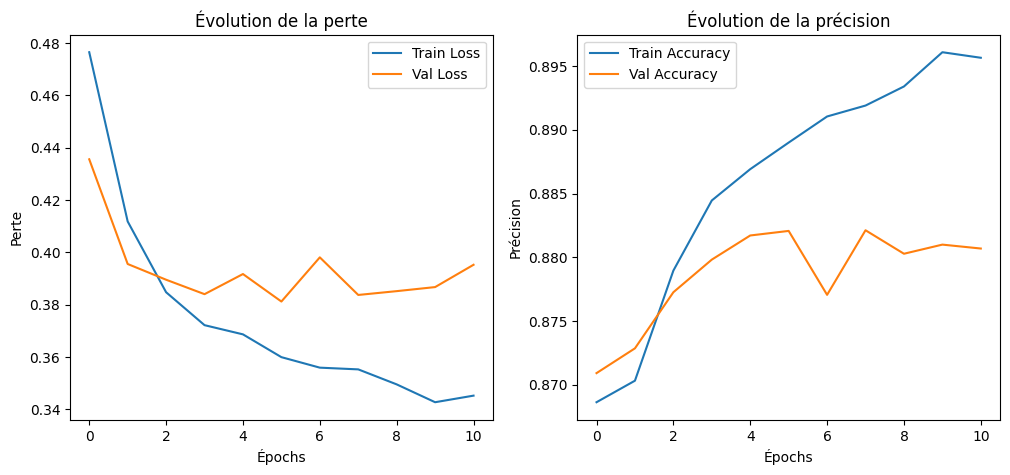

In [56]:
# Courbes de l'entraînement
plt.figure(figsize=(12, 5))

# Perte
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Épochs")
plt.ylabel("Perte")
plt.legend()
plt.title("Évolution de la perte")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Épochs")
plt.ylabel("Précision")
plt.legend()
plt.title("Évolution de la précision")

plt.show()


In [57]:
loss, accuracy = model_rnn.evaluate(X_test_padded, y_test_onehot)
print(f'Précision : {accuracy * 100:.2f}%')


 33/611 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8805 - loss: 0.4030

611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8831 - loss: 0.3803
Précision : 88.21%


  1/611 ━━━━━━━━━━━━━━━━━━━━ 1:20 132ms/step

611/611 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

              precision    recall  f1-score   support

           0       0.56      0.33      0.42      1597
           1       0.00      0.00      0.00       921
           2       0.90      0.98      0.94     17010

    accuracy                           0.88     19528
   macro avg       0.49      0.44      0.45     19528
weighted avg       0.83      0.88      0.85     19528



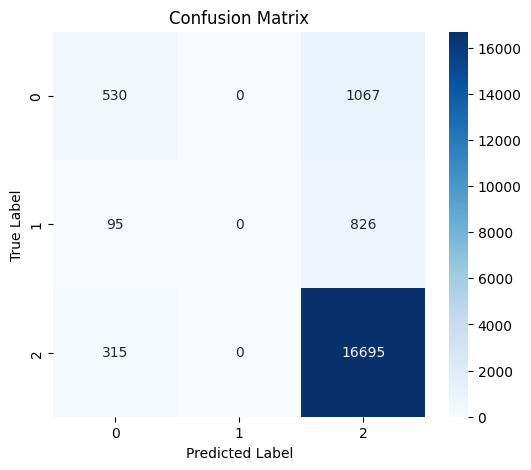

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Predict
predictions = model_rnn.predict(X_test_padded)

# Step 2: Convert to class labels
predicted_labels = predictions.argmax(axis=1)
true_labels = y_test_onehot.argmax(axis=1)

# Step 3: Classification Report
print(classification_report(true_labels, predicted_labels))

# Step 4: Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


### 2-2 LSTM

In [60]:
from tensorflow.keras.regularizers import l2
model_lstm = Sequential([
    Embedding(10000, 64,  input_shape=(None,)),
    Dropout(0.2),
    LSTM(32, return_sequences=False,  
         recurrent_dropout=0.2,     
         kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model_lstm.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_lstm.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 652,515 (2.49 MB)

 Trainable params: 652,515 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
print(f"\n🔹 Entraînement du modèle LSTM ..........")
history = model_lstm.fit(X_train_padded, y_train_onehot,
                         validation_data=(X_test_padded, y_test_onehot),
                         batch_size=32,
                         epochs=20, callbacks=[early_stopping])


🔹 Entraînement du modèle LSTM ..........
Epoch 1/20


2441/2441 ━━━━━━━━━━━━━━━━━━━━ 72s 29ms/step - accuracy: 0.8702 - loss: 0.5114 - val_accuracy: 0.8714 - val_loss: 0.4915
Epoch 2/20
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 70s 29ms/step - accuracy: 0.8701 - loss: 0.4299 - val_accuracy: 0.8720 - val_loss: 0.4054
Epoch 3/20
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 70s 29ms/step - accuracy: 0.8738 - loss: 0.4088 - val_accuracy: 0.8746 - val_loss: 0.4220
Epoch 4/20
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 70s 29ms/step - accuracy: 0.8858 - loss: 0.4075 - val_accuracy: 0.8893 - val_loss: 0.3918
Epoch 5/20
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 70s 29ms/step - accuracy: 0.8904 - loss: 0.4071 - val_accuracy: 0.8874 - val_loss: 0.3896
Epoch 6/20
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 70s 29ms/step - accuracy: 0.8873 - loss: 0.3917 - val_accuracy: 0.8775 - val_loss: 0.3896
Epoch 7/20
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 71s 29ms/step - accuracy: 0.8826 - loss: 0.3925 - val_accuracy: 0.8916 - val_loss: 0.3974
Epoch 8/20
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - accuracy: 0.8930 - loss: 0.38

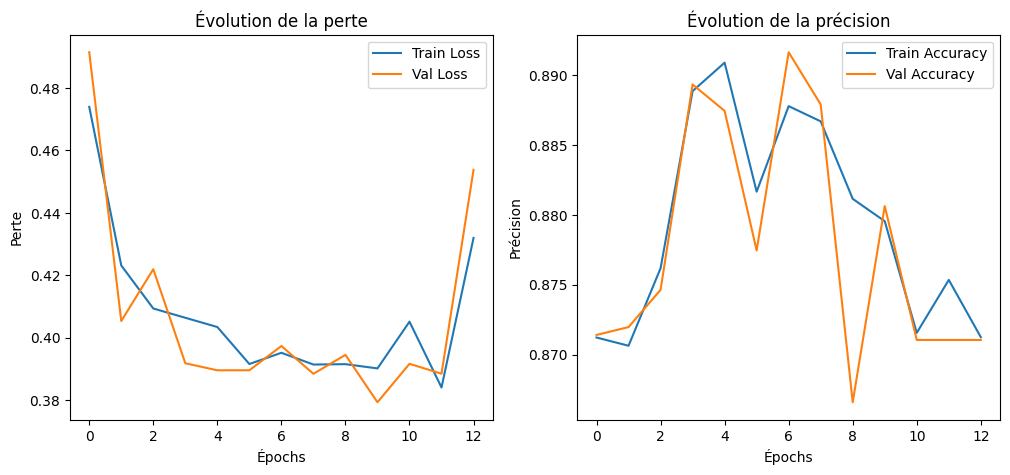

In [63]:
# Courbes de l'entraînement
plt.figure(figsize=(12, 5))

# Perte
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Épochs")
plt.ylabel("Perte")
plt.legend()
plt.title("Évolution de la perte")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Épochs")
plt.ylabel("Précision")
plt.legend()
plt.title("Évolution de la précision")

plt.show()


In [64]:
loss, accuracy = model_lstm.evaluate(X_test_padded, y_test_onehot)
print(f'Précision : {accuracy * 100:.2f}%')

 17/611 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8743 - loss: 0.3996

611/611 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8785 - loss: 0.3799
Précision : 88.06%


611/611 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
              precision    recall  f1-score   support

           0       0.48      0.61      0.54      1597
           1       0.00      0.00      0.00       921
           2       0.93      0.95      0.94     17010

    accuracy                           0.88     19528
   macro avg       0.47      0.52      0.49     19528
weighted avg       0.85      0.88      0.86     19528



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

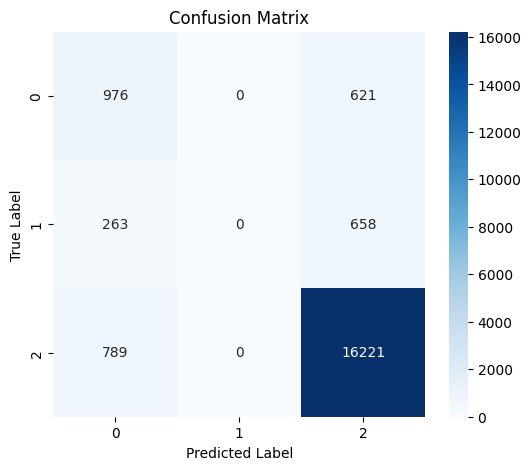

In [65]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Predict
predictions = model_lstm.predict(X_test_padded)

# Step 2: Convert to class labels
predicted_labels = predictions.argmax(axis=1);
true_labels = y_test_onehot.argmax(axis=1)

# Step 3: Classification Report
print(classification_report(true_labels, predicted_labels))

# Step 4: Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


### 2-3 GRU

In [67]:
model_gru = Sequential([
    Embedding(10000, 64, input_shape=(None,)),  
    
  
    Dropout(0.2),
    
    
    GRU(32, return_sequences=False,  
        recurrent_dropout=0.2,       
        kernel_regularizer=l2(0.001)),  

    Dropout(0.5),
    
    Dense(num_classes, activation="softmax")
])


model_gru.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy"]
)
early_stopping = EarlyStopping(
    monitor='val_loss',     
    patience=2,             
    restore_best_weights=True, 
    verbose=1             
)
model_gru.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 649,507 (2.48 MB)

 Trainable params: 649,507 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
print(f"\n🔹 Entraînement du modèle GRU ..........")
history = model_gru.fit(X_train_padded, y_train_onehot,
                         validation_data=(X_test_padded, y_test_onehot),
                         batch_size=32,
                         epochs=10,callbacks=[early_stopping])


🔹 Entraînement du modèle GRU ..........
Epoch 1/10


2441/2441 ━━━━━━━━━━━━━━━━━━━━ 75s 30ms/step - accuracy: 0.8695 - loss: 0.5146 - val_accuracy: 0.8947 - val_loss: 0.3560
Epoch 2/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 73s 30ms/step - accuracy: 0.8963 - loss: 0.3573 - val_accuracy: 0.9023 - val_loss: 0.3304
Epoch 3/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 73s 30ms/step - accuracy: 0.9033 - loss: 0.3315 - val_accuracy: 0.9014 - val_loss: 0.3309
Epoch 4/10
2441/2441 ━━━━━━━━━━━━━━━━━━━━ 72s 29ms/step - accuracy: 0.9068 - loss: 0.3204 - val_accuracy: 0.9006 - val_loss: 0.3330
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


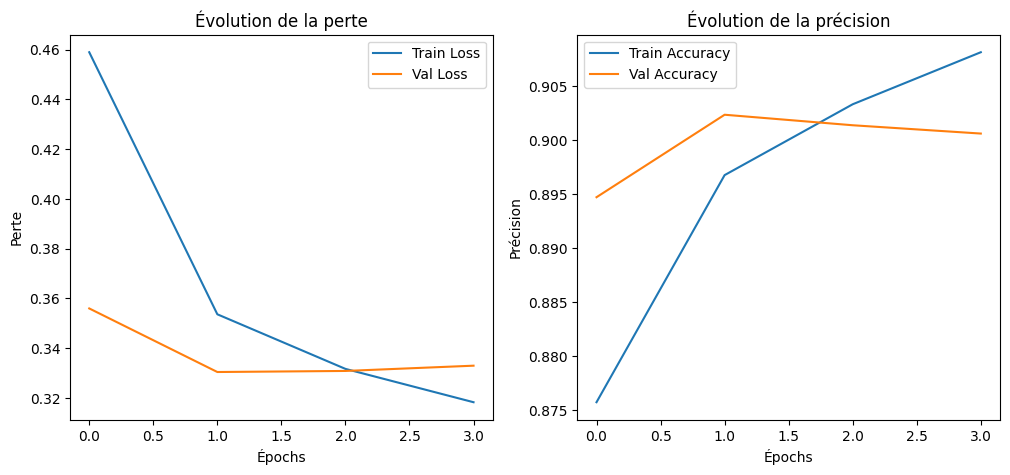

In [69]:
# Courbes de l'entraînement
plt.figure(figsize=(12, 5))

# Perte
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Épochs")
plt.ylabel("Perte")
plt.legend()
plt.title("Évolution de la perte")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Épochs")
plt.ylabel("Précision")
plt.legend()
plt.title("Évolution de la précision")

plt.show()


In [70]:
loss, accuracy = model_gru.evaluate(X_test_padded, y_test_onehot)
print(f'Précision : {accuracy * 100:.2f}%')

 17/611 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8918 - loss: 0.3617

611/611 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9011 - loss: 0.3337
Précision : 90.23%


611/611 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
              precision    recall  f1-score   support

           0       0.65      0.56      0.60      1597
           1       0.00      0.00      0.00       921
           2       0.92      0.98      0.95     17010

    accuracy                           0.90     19528
   macro avg       0.52      0.52      0.52     19528
weighted avg       0.86      0.90      0.88     19528



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

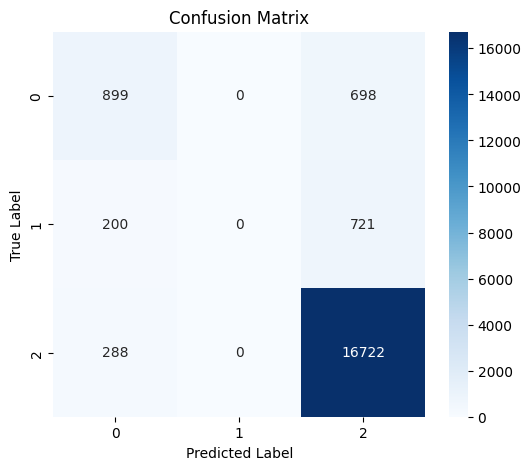

In [71]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Predict
predictions = model_gru.predict(X_test_padded)
predicted_labels = predictions.argmax(axis=1)
true_labels = y_test_onehot.argmax(axis=1)

# Step 2: Classification Report
print(classification_report(true_labels, predicted_labels))

# Step 3: Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])  # Adjust labels as needed
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# 3- Ajout du Mécanisme d'Attention

## RNN with Attention

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, Attention, GlobalAveragePooling1D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Définition des entrées
inputs = Input(shape=(50,))  # 50 = MAX_SEQUENCE_LENGTH

# Embedding
embedding = Embedding(10000, 64, input_length=50)(inputs)

embedding_dropout = Dropout(0.2)(embedding)

# RNN
rnn_output = SimpleRNN(32, return_sequences=True, 
                      recurrent_regularizer=l2(0.001),
                      kernel_regularizer=l2(0.001))(embedding_dropout)

# Ajout du Mécanisme d'Attention
query = Dense(32)(rnn_output)  # Transformation en Query
attention = Attention()([query, rnn_output])  # Application de l'attention

attention_dropout = Dropout(0.3)(attention)

# Global Average Pooling pour condenser l'information
context_vector = GlobalAveragePooling1D()(attention_dropout)

intermediate = Dense(16, activation="relu", kernel_regularizer=l2(0.001))(context_vector)
intermediate = Dropout(0.4)(intermediate)

# Couche de classification (déjà présente)
output = Dense(3, activation="softmax")(intermediate)

# Définition du modèle final
model_rnn_attention = Model(inputs, output)

# Compilation du modèle
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_rnn_attention.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Affichage du résumé du modèle
model_rnn_attention.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 50, 64)               640000    ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 50, 64)               0         ['embedding[0][0]']           
                                                                                                  
 simple_rnn (SimpleRNN)      (None, 50, 32)               3104      ['dropout[0][0]']             
                                                                                              

2025-03-03 23:59:22.734019: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 41155 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:34:00.0, compute capability: 8.9


                                                                     'simple_rnn[0][0]']          
                                                                                                  
 dropout_1 (Dropout)         (None, 50, 32)               0         ['attention[0][0]']           
                                                                                                  
 global_average_pooling1d (  (None, 32)                   0         ['dropout_1[0][0]']           
 GlobalAveragePooling1D)                                                                          
                                                                                                  
 dense_1 (Dense)             (None, 16)                   528       ['global_average_pooling1d[0][
                                                                    0]']                          
                                                                                                  
 dropout_2

In [27]:
print(f"\n🔹 Entraînement du modèle RNN avec la couche d'attention ..........")
model_rnn_attention.fit(X_train_padded, y_train_onehot, epochs=30, batch_size=32,     validation_split=0.2,  callbacks=[early_stopping])



🔹 Entraînement du modèle RNN avec la couche d'attention ..........
Epoch 1/30


2025-03-03 23:59:31.617632: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5d68702ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-03 23:59:31.617663: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-03-03 23:59:31.622636: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-03 23:59:31.636862: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1741046371.714257  138632 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1999/1999 [==============================] - 72s 34ms/step - loss: 0.5178 - accuracy: 0.8692 - val_loss: 0.4314 - val_accuracy: 0.8740
Epoch 2/30
1999/1999 [==============================] - 50s 25ms/step - loss: 0.4117 - accuracy: 0.8712 - val_loss: 0.3808 - val_accuracy: 0.8740
Epoch 3/30
1999/1999 [==============================] - 49s 25ms/step - loss: 0.3681 - accuracy: 0.8869 - val_loss: 0.3641 - val_accuracy: 0.8957
Epoch 4/30
1999/1999 [==============================] - 49s 25ms/step - loss: 0.3493 - accuracy: 0.9035 - val_loss: 0.3558 - val_accuracy: 0.8967
Epoch 5/30
1999/1999 [==============================] - 49s 25ms/step - loss: 0.3393 - accuracy: 0.9056 - val_loss: 0.3605 - val_accuracy: 0.8947
Epoch 6/30
1999/1999 [==============================] - 49s 24ms/step - loss: 0.3310 - accuracy: 0.9090 - val_loss: 0.3667 - val_accuracy: 0.8965
Epoch 7/30
1999/1999 [==============================] - 49s 24ms/step - loss: 0.3240 - accuracy: 0.9106 - val_loss: 0.3600 - val_accura

In [28]:
loss, accuracy = model_rnn_attention.evaluate(X_test_padded, y_test_onehot)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


 25/625 [>.............................] - ETA: 2s - loss: 0.3684 - accuracy: 0.8800

625/625 [==============================] - 3s 5ms/step - loss: 0.3538 - accuracy: 0.8954
Test Accuracy: 89.54%


In [29]:
predictions = model_rnn_attention.predict(X_test_padded)
predicted_labels = predictions.argmax(axis=1)
true_labels = y_test_onehot.argmax(axis=1)


  1/625 [..............................] - ETA: 1:18

625/625 [==============================] - 3s 4ms/step


In [30]:

print(classification_report(true_labels, predicted_labels))


              precision    recall  f1-score   support

           0       0.63      0.47      0.54      1623
           1       0.00      0.00      0.00       940
           2       0.91      0.98      0.95     17422

    accuracy                           0.90     19985
   macro avg       0.51      0.48      0.49     19985
weighted avg       0.85      0.90      0.87     19985



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

## LSTM & Attention

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, GlobalAveragePooling1D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf

# Définition des entrées
inputs = Input(shape=(50,))  # 50 = MAX_SEQUENCE_LENGTH

# Embedding avec dimensionnalité réduite pour éviter le surapprentissage
embedding = Embedding(10000, 64)(inputs)  # Réduit de 128 à 64

# Ajout de dropout après l'embedding
embedding_dropout = Dropout(0.2)(embedding)

# Couche LSTM avec régularisation
lstm_output = LSTM(32, return_sequences=True, 
                 recurrent_regularizer=l2(0.001),
                 kernel_regularizer=l2(0.001))(embedding_dropout)  # Réduit de 64 à 32

# Mécanisme d'attention
query = Dense(32)(lstm_output)  # Dimension réduite pour correspondre à la sortie LSTM
attention = Attention()([query, lstm_output])

# Dropout après l'attention
attention_dropout = Dropout(0.3)(attention)

# Global Average Pooling pour condenser l'information
context_vector = GlobalAveragePooling1D()(attention_dropout)

# Couche dense intermédiaire pour plus d'expressivité
intermediate = Dense(16, activation="relu", kernel_regularizer=l2(0.001))(context_vector)
intermediate = Dropout(0.4)(intermediate)

# Couche de classification
output = Dense(3, activation="softmax")(intermediate)  # En supposant num_classes = 3

# Définition du modèle final
model_lstm_attention = Model(inputs, output)

# Compilation avec un optimiseur à taux d'apprentissage contrôlé
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_lstm_attention.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Définition du callback d'early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Affichage du résumé du modèle
model_lstm_attention.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 50, 64)               640000    ['input_2[0][0]']             
                                                                                                  
 dropout_3 (Dropout)         (None, 50, 64)               0         ['embedding_1[0][0]']         
                                                                                                  
 lstm (LSTM)                 (None, 50, 32)               12416     ['dropout_3[0][0]']           
                                                                                            

In [32]:
history = model_lstm_attention.fit(X_train_padded, y_train_onehot,
                         validation_data=(X_test_padded, y_test_onehot),
                         batch_size=32,
                         callbacks=[early_stopping],
                         epochs=10)
                         # Entraînement du modèle

Epoch 1/10


W0000 00:00:1741046965.649083  116998 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA L40S" frequency: 2520 num_cores: 142 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 100663296 shared_memory_size_per_multiprocessor: 102400 memory_size: 43154407424 bandwidth: 864096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


2499/2499 [==============================] - ETA: 0s - loss: 0.4213 - accuracy: 0.8890

W0000 00:00:1741046990.096062  116998 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA L40S" frequency: 2520 num_cores: 142 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 100663296 shared_memory_size_per_multiprocessor: 102400 memory_size: 43154407424 bandwidth: 864096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


2499/2499 [==============================] - 27s 10ms/step - loss: 0.4213 - accuracy: 0.8890 - val_loss: 0.3427 - val_accuracy: 0.8984
Epoch 2/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.3472 - accuracy: 0.8993 - val_loss: 0.3397 - val_accuracy: 0.8991
Epoch 3/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.3331 - accuracy: 0.9023 - val_loss: 0.3412 - val_accuracy: 0.8982
Epoch 4/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.3259 - accuracy: 0.9041 - val_loss: 0.3431 - val_accuracy: 0.9006
Epoch 5/10
2499/2499 [==============================] - 13s 5ms/step - loss: 0.3199 - accuracy: 0.9068 - val_loss: 0.3418 - val_accuracy: 0.8982
Epoch 5: early stopping


In [33]:
#evaluation de modele
loss, accuracy = model_lstm_attention.evaluate(X_test_padded, y_test_onehot)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


 44/625 [=>............................] - ETA: 1s - loss: 0.3649 - accuracy: 0.8835

625/625 [==============================] - 1s 2ms/step - loss: 0.3397 - accuracy: 0.8991
Test Accuracy: 89.91%


In [34]:
#faire les prédictions
predictions = model_lstm_attention.predict(X_test_padded)
predicted_labels = predictions.argmax(axis=1)  # Convert softmax probabilities to class labels

 85/625 [===>..........................] - ETA: 0s

W0000 00:00:1741047284.721264  116998 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA L40S" frequency: 2520 num_cores: 142 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 100663296 shared_memory_size_per_multiprocessor: 102400 memory_size: 43154407424 bandwidth: 864096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


625/625 [==============================] - 1s 2ms/step


In [35]:
print(classification_report(y_test_onehot.argmax(axis=1), predicted_labels))


              precision    recall  f1-score   support

           0       0.61      0.55      0.58      1623
           1       0.00      0.00      0.00       940
           2       0.92      0.98      0.95     17422

    accuracy                           0.90     19985
   macro avg       0.51      0.51      0.51     19985
weighted avg       0.85      0.90      0.88     19985



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

# Visualisation graphique

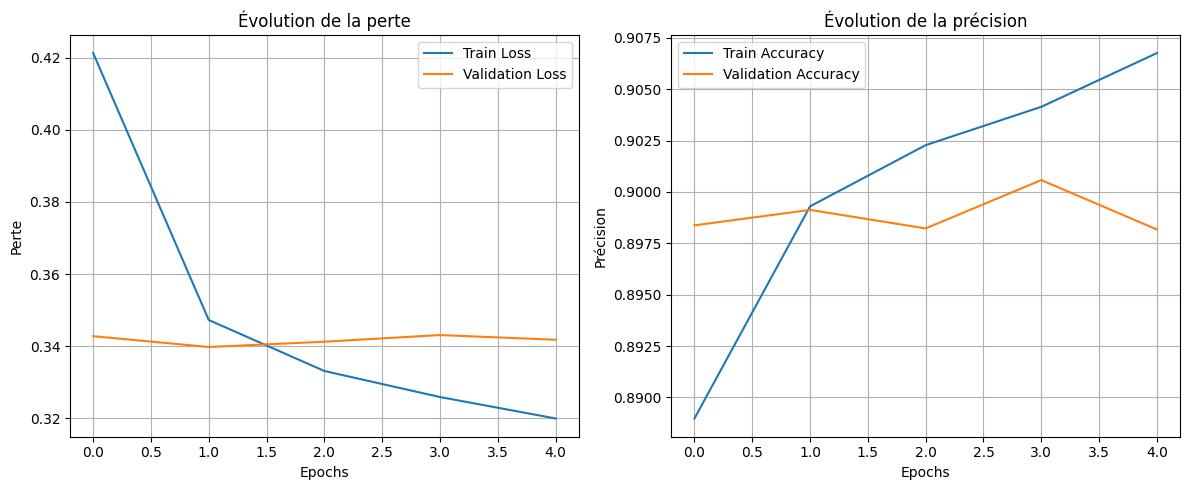

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Évolution de la perte')
plt.xlabel('Epochs')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Évolution de la précision')
plt.xlabel('Epochs')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('courbes_apprentissage_lstm_attention.png', dpi=300)
plt.show()

## GRU with Attention

In [37]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Attention, GlobalAveragePooling1D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Définition des entrées
inputs = Input(shape=(50,))  # 50 = MAX_SEQUENCE_LENGTH

# Embedding
embedding = Embedding(10000, 64, input_length=50)(inputs)

# Ajout de dropout après l'embedding
embedding_dropout = Dropout(0.2)(embedding)

# GRU au lieu de LSTM
gru_output = GRU(32, return_sequences=True, 
                recurrent_regularizer=l2(0.001),
                kernel_regularizer=l2(0.001))(embedding_dropout)

# Ajout du Mécanisme d'Attention
query = Dense(32)(gru_output)  # Transformation en Query
attention = Attention()([query, gru_output])  # Application de l'attention

# Dropout après l'attention
attention_dropout = Dropout(0.3)(attention)

# Global Average Pooling pour condenser l'information
context_vector = GlobalAveragePooling1D()(attention_dropout)

# Couche dense intermédiaire
intermediate = Dense(16, activation="relu", kernel_regularizer=l2(0.001))(context_vector)
intermediate = Dropout(0.4)(intermediate)

# Couche de classification
output = Dense(3, activation="softmax")(intermediate)

# Définition du modèle final
model_gru_attention = Model(inputs, output)

# Compilation du modèle
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_gru_attention.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Définition du callback d'early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Affichage du résumé du modèle
model_gru_attention.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 50, 64)               640000    ['input_3[0][0]']             
                                                                                                  
 dropout_6 (Dropout)         (None, 50, 64)               0         ['embedding_2[0][0]']         
                                                                                                  
 gru (GRU)                   (None, 50, 32)               9408      ['dropout_6[0][0]']           
                                                                                            

In [38]:
# Entraînement du modèle avec les données prétraitées comme pour le LSTM
history = model_gru_attention.fit(
    X_train_padded, y_train_onehot,
    validation_data=(X_test_padded, y_test_onehot),
    batch_size=32,
    callbacks=[early_stopping],
    epochs=20  
)

Epoch 1/20


W0000 00:00:1741047316.058857  116998 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA L40S" frequency: 2520 num_cores: 142 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 100663296 shared_memory_size_per_multiprocessor: 102400 memory_size: 43154407424 bandwidth: 864096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


2499/2499 [==============================] - ETA: 0s - loss: 0.4182 - accuracy: 0.8841

W0000 00:00:1741047339.504863  116998 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA L40S" frequency: 2520 num_cores: 142 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 100663296 shared_memory_size_per_multiprocessor: 102400 memory_size: 43154407424 bandwidth: 864096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


2499/2499 [==============================] - 26s 10ms/step - loss: 0.4182 - accuracy: 0.8841 - val_loss: 0.3466 - val_accuracy: 0.8989
Epoch 2/20
2499/2499 [==============================] - 13s 5ms/step - loss: 0.3515 - accuracy: 0.8971 - val_loss: 0.3396 - val_accuracy: 0.8970
Epoch 3/20
2499/2499 [==============================] - 13s 5ms/step - loss: 0.3388 - accuracy: 0.8994 - val_loss: 0.3399 - val_accuracy: 0.8980
Epoch 4/20
2499/2499 [==============================] - 13s 5ms/step - loss: 0.3307 - accuracy: 0.9023 - val_loss: 0.3423 - val_accuracy: 0.8990
Epoch 5/20
2499/2499 [==============================] - 13s 5ms/step - loss: 0.3253 - accuracy: 0.9044 - val_loss: 0.3418 - val_accuracy: 0.8977
Epoch 6/20
2499/2499 [==============================] - 13s 5ms/step - loss: 0.3205 - accuracy: 0.9058 - val_loss: 0.3427 - val_accuracy: 0.8966
Epoch 7/20
2499/2499 [==============================] - 12s 5ms/step - loss: 0.3179 - accuracy: 0.9074 - val_loss: 0.3506 - val_accuracy: 0.

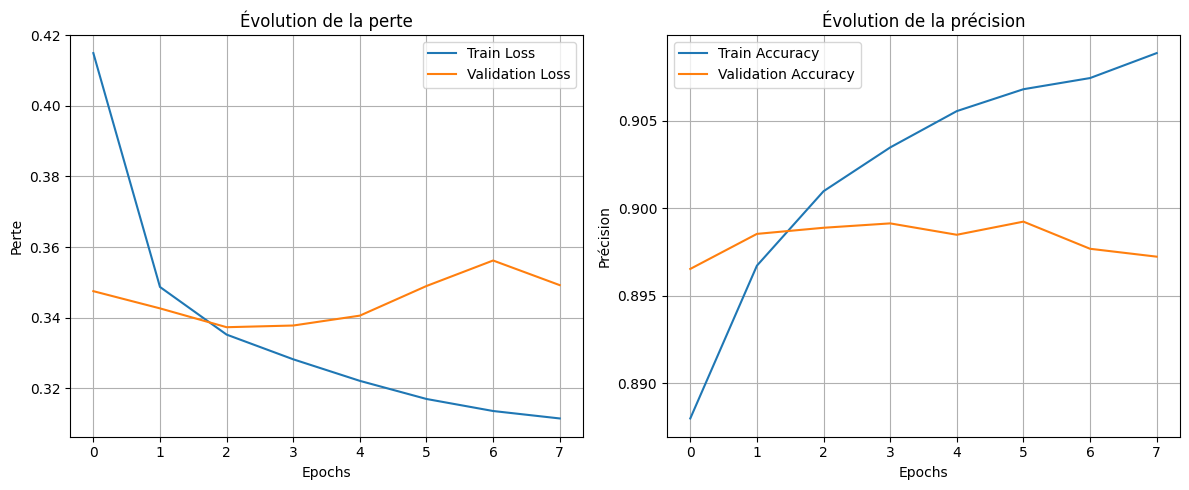

In [43]:
# Traçage des courbes d'apprentissage
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Évolution de la perte')
plt.xlabel('Epochs')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Évolution de la précision')
plt.xlabel('Epochs')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('courbes_apprentissage_gru_attention.png', dpi=300)
plt.show()

In [44]:
loss, accuracy = model_gru_attention.evaluate(X_test_padded, y_test_onehot)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


 46/625 [=>............................] - ETA: 1s - loss: 0.3572 - accuracy: 0.8818

625/625 [==============================] - 1s 2ms/step - loss: 0.3373 - accuracy: 0.8989
Test Accuracy: 89.89%


In [45]:
predictions = model_gru_attention.predict(X_test_padded)
predicted_labels = predictions.argmax(axis=1)
true_labels = y_test_onehot.argmax(axis=1)
print(classification_report(true_labels, predicted_labels))


 87/625 [===>..........................] - ETA: 0s

W0000 00:00:1741042627.833638    1635 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA L40S" frequency: 2520 num_cores: 142 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 100663296 shared_memory_size_per_multiprocessor: 102400 memory_size: 45748584448 bandwidth: 864096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


625/625 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.63      0.53      0.58      1623
           1       0.00      0.00      0.00       940
           2       0.92      0.98      0.95     17422

    accuracy                           0.90     19985
   macro avg       0.52      0.50      0.51     19985
weighted avg       0.85      0.90      0.87     19985



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

# 4- Modélisation avec Transformers

In [9]:
!pip install torch

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import  get_scheduler
from torch.optim import AdamW

# Initialisation du Tokenizer BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def encode_texts(texts, max_length=50):
    return tokenizer(texts.tolist(), padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")

X_train_encoded = encode_texts(X_train)
X_test_encoded = encode_texts(X_test)

# Convert en tenseurs
try:
    if hasattr(y_train, 'numpy'):  # pandas Series/DataFrame
        y_train_tensor = torch.tensor(y_train.numpy())
        y_test_tensor = torch.tensor(y_test.numpy())
    elif hasattr(y_train, 'to_numpy'): 
        y_train_tensor = torch.tensor(y_train.to_numpy())
        y_test_tensor = torch.tensor(y_test.to_numpy())
    else:  
        y_train_tensor = torch.tensor(np.array(y_train))
        y_test_tensor = torch.tensor(np.array(y_test))
except Exception as e:
    y_train_list = [int(label) for label in y_train]
    y_test_list = [int(label) for label in y_test]
    y_train_tensor = torch.tensor(y_train_list)
    y_test_tensor = torch.tensor(y_test_list)

In [21]:
# Création du DataLoader
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

train_dataset = SentimentDataset(X_train_encoded, y_train_tensor)
test_dataset = SentimentDataset(X_test_encoded, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Chargement du modèle BERT pour classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Optimisation avec AdamW
optimizer = AdamW(model.parameters(), lr=2e-5)

# Scheduler pour un Learning Rate Adaptatif
num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Entraînement du modèle
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

epochs = 3
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch + 1} terminé.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 terminé.
Epoch 2 terminé.
Epoch 3 terminé.


In [22]:
# Évaluation
from sklearn.metrics import accuracy_score
# Mise en mode évaluation
model.eval()

all_preds = []
all_labels = [] 

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        predictions = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)

print(f"\n✅ Précision finale : {accuracy * 100:.2f}%")


✅ Précision finale : 90.19%



🔍 Rapport de classification :

              precision    recall  f1-score   support

    Classe 0       0.68      0.58      0.63      1623
    Classe 1       0.27      0.11      0.15       940
    Classe 2       0.93      0.98      0.95     17422

    accuracy                           0.90     19985
   macro avg       0.63      0.55      0.58     19985
weighted avg       0.88      0.90      0.89     19985



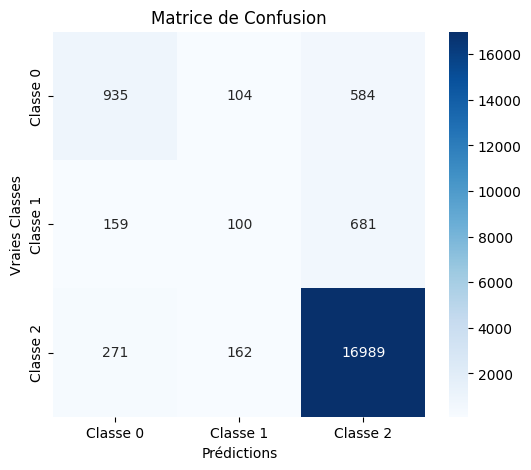

In [23]:
# Rapport de classification (Precision, Recall, F1-score)
print("\n🔍 Rapport de classification :\n")
print(classification_report(all_labels, all_preds, target_names=["Classe 0", "Classe 1", "Classe 2"]))

# Matrice de confusion
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1", "Classe 2"], yticklabels=["Classe 0", "Classe 1", "Classe 2"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies Classes")
plt.title("Matrice de Confusion")
plt.show()

# Comparaison entre les modèles

In [39]:
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# Fonction pour évaluer le modèle
def evaluate_model(y_true, y_pred_probs, model_name):
    # Convertir en numpy array si nécessaire
    y_pred_probs = np.array(y_pred_probs)  
    y_true = np.array(y_true)  

    # Vérifier la forme des données
    print(f"\n🔍 Vérification pour {model_name}:")
    print(f"Shape y_true: {y_true.shape}, Shape y_pred_probs: {y_pred_probs.shape}")  # Debug

    # Adapter argmax selon la forme des prédictions
    if y_pred_probs.ndim == 1:  
        y_pred_classes = y_pred_probs  # Déjà des classes  
    else:  
        y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # Adapter y_true selon sa dimension
    if y_true.ndim == 1:
        y_true_classes = y_true  # Déjà sous forme de classes
    else:
        y_true_classes = np.argmax(y_true, axis=1)  # Convertir si one-hot

    # Calculer AUC-ROC (gérer l'erreur si impossible à calculer)
    try:
        auc_score = roc_auc_score(y_true, y_pred_probs, average="macro", multi_class="ovr")
    except ValueError:
        auc_score = "N/A"  # Si AUC ne peut pas être calculé

    # Calculer les autres métriques
    f1 = f1_score(y_true_classes, y_pred_classes, average="macro")
    precision = precision_score(y_true_classes, y_pred_classes, average="macro")
    recall = recall_score(y_true_classes, y_pred_classes, average="macro")

    # Affichage des résultats
    print(f"AUC {model_name}: {auc_score} | F1: {f1} | Precision: {precision} | Recall: {recall}")
    
    return auc_score, f1, precision, recall

# Vérification des prédictions pour chaque modèle
results = {}

if 'all_preds' in locals() and all_preds is not None:
    results["BERT"] = evaluate_model(all_labels, all_preds, "BERT")
else:
    results["BERT"] = ("N/A", "N/A", "N/A", "N/A")

results["GRU"] = evaluate_model(y_test_onehot, model_gru_attention.predict(X_test_padded), "GRU")
results["LSTM"] = evaluate_model(y_test_onehot, model_lstm_attention.predict(X_test_padded), "LSTM")
results["RNN"] = evaluate_model(y_test_onehot, model_rnn_attention.predict(X_test_padded), "RNN")

# Affichage comparatif final
print("\n📊 **Comparaison des modèles** 📊")
for model, metrics in results.items():
    print(f"{model}: AUC={metrics[0]}, F1={metrics[1]}, Precision={metrics[2]}, Recall={metrics[3]}")



🔍 Vérification pour BERT:
Shape y_true: (19985,), Shape y_pred_probs: (19985,)
AUC BERT: N/A | F1: 0.5771270050016037 | Precision: 0.6296352830730205 | Recall: 0.5525409997046364
 85/625 [===>..........................] - ETA: 0s

W0000 00:00:1741047487.264997  116998 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA L40S" frequency: 2520 num_cores: 142 environment { key: "architecture" value: "8.9" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 100663296 shared_memory_size_per_multiprocessor: 102400 memory_size: 43154407424 bandwidth: 864096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


625/625 [==============================] - 1s 2ms/step

🔍 Vérification pour GRU:
Shape y_true: (19985, 3), Shape y_pred_probs: (19985, 3)
AUC GRU: 0.8342202513933531 | F1: 0.5055438811041763 | Precision: 0.504935545587844 | Recall: 0.5074333721909152
 82/625 [==>...........................] - ETA: 1s

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


625/625 [==============================] - 1s 2ms/step

🔍 Vérification pour LSTM:
Shape y_true: (19985, 3), Shape y_pred_probs: (19985, 3)
AUC LSTM: 0.8315407530632409 | F1: 0.5100060426213687 | Precision: 0.511635520064874 | Recall: 0.5101185676125345
 27/625 [>.............................] - ETA: 2s

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


625/625 [==============================] - 3s 4ms/step

🔍 Vérification pour RNN:
Shape y_true: (19985, 3), Shape y_pred_probs: (19985, 3)
AUC RNN: 0.8247622905114577 | F1: 0.49478956026373 | Precision: 0.5128244697264923 | Recall: 0.48484384549870835

📊 **Comparaison des modèles** 📊
BERT: AUC=N/A, F1=0.5771270050016037, Precision=0.6296352830730205, Recall=0.5525409997046364
GRU: AUC=0.8342202513933531, F1=0.5055438811041763, Precision=0.504935545587844, Recall=0.5074333721909152
LSTM: AUC=0.8315407530632409, F1=0.5100060426213687, Precision=0.511635520064874, Recall=0.5101185676125345
RNN: AUC=0.8247622905114577, F1=0.49478956026373, Precision=0.5128244697264923, Recall=0.48484384549870835


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
